# Import required libraries :

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense , Input
from tensorflow.keras.optimizers import Adam
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold , train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , roc_curve , roc_auc_score
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

In [98]:
print(tf.__version__)

2.8.0


# Import data :

In [99]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
df_x=pd.read_csv("/content/drive/MyDrive/tox21/tox21_x.csv")
y=pd.read_csv("/content/drive/MyDrive/tox21/tox21_y.csv")
y=np.squeeze(y)

In [101]:
df_x.shape

(7237, 190)

In [102]:
df_x.head()

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,189,190,191,192,193,194,195,196,197,198,199,200,201
0,0.934799,0.177418,0.046765,0.033326,0.060566,0.039962,0.029073,0.141434,0.024657,0.228561,0.025139,0.268049,0.034317,0.282035,7.426378e-01,4.562858e-01,6.893569e-07,0.179159,0.509277,4.086641e-01,9.258417e-11,6.674678e-01,0.477870,1.583304e-01,5.915087e-01,0.077751,0.974430,0.973245,0.940471,0.274299,0.925753,0.043509,0.087954,0.049894,0.031270,0.281892,0.043682,0.104644,0.853856,0.104644,...,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,9.999565e-01,5.766101e-14,2.957989e-11,0.168378,1.00000,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.975867
1,0.875932,0.047173,0.029397,0.031876,0.021488,0.033104,0.040950,0.025747,0.036181,0.019621,0.065222,0.037671,0.083423,0.050252,6.070471e-01,5.113023e-01,6.893569e-07,0.423808,0.159301,1.477604e-01,6.062958e-01,4.088913e-01,0.651997,1.691932e-01,7.522456e-13,0.020446,0.821542,0.681483,0.424732,0.353508,0.812619,0.030800,0.021093,0.020666,0.022066,0.205883,0.025120,0.181274,0.126957,0.181274,...,6.246014e-10,0.168149,0.165451,1.000000e+00,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,1.000000,0.738638
2,0.967576,0.059713,0.178132,0.308372,0.257215,0.133949,0.290161,0.221362,0.231685,0.153900,0.271372,0.182168,0.305545,0.207125,4.074888e-10,2.648697e-01,6.893569e-07,0.424202,0.019674,8.475976e-01,9.258417e-11,5.856109e-17,0.659582,7.746562e-01,7.522456e-13,0.112433,0.715690,0.440084,0.192273,0.846762,0.904752,0.137062,0.087870,0.329193,0.496475,0.516555,0.156032,0.415653,0.126590,0.415653,...,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.999908,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.878233
3,0.998591,0.009412,0.013743,0.002718,0.008883,0.002707,0.001133,0.048074,0.004498,0.305146,0.003762,0.408753,0.000218,0.036357,8.673069e-01,4.902053e-01,6.893569e-07,0.100218,0.170301,2.509948e-11,9.258417e-11,5.856109e-17,0.000001,2.391450e-11,8.932598e-01,0.021569,0.294906,0.022320,0.004061,0.999390,0.992056,0.005699,0.025005,0.048679,0.003889,0.274429,0.003372,0.063865,0.191146,0.063865,...,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.168186,0.009089,0.168363,8.265423e-11,0.156346,0.0,0.0,0.021135,0.021135,2.388156e-20,0.0,8.336725e-25,0.156951,4.034345e-08,1.552592e-23,1.593061e-17,5.766101e-14,2.957989e-11,0.168378,0.16738,1.481515e-18,2.324150e-16,4.703598e-08,0.166633,0.193474
4,0.996279,0.014875,0.248635,0.451559,0.397276,0.081282,0.249279,0.185958,0.757884,0.673664,0.055368,0.031621,0.026680,0.015320,4.074888e-10,2.175235e-08,6.893569e-07,0.748845,0.019674,3.327549e-01,9.258417e-11,5.856109e-17,0.775594,2.391450e-11,8.300604e-01,0.145539,0.003417,0.002654,0.001724,0.999390,0.984562,0.137062,0.103966,0.560758,0.293420,0.969959,0.166428,0.016589,0.061013,0.016589,...,6.246014e-10,0.168149,0.165451,1.171103e-13,0.0,0.164669,0.166925,0.0,5.100713e-08,7.105427e-15,0.154654,2.794209e-22,0.0,0.16764,6.314993e-25,0.1681



### Checking the distribution of labels :

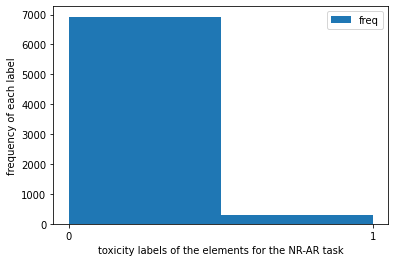

In [103]:
plt.hist(y,label='freq',bins=2)
plt.legend(loc="upper right")
plt.xticks(range(0,2))
plt.xlabel('toxicity labels of the elements for the NR-AR task')
plt.ylabel('frequency of each label')
plt.show()

Regarding the imbalanced label set, we are prone to overfitting. So, to mitigate this issue, we will use K-fold cross validation.

---------------
# Neural Network
---------------

## Data Splitting for Neural Network model







In [104]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.1, random_state=23)

In [105]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6513, 190)
(6513,)
(724, 190)
(724,)


In [106]:
y_train.value_counts()

0.0    6233
1.0     280
Name: NR-AR, dtype: int64

# Building and Training our Neural Network architucture:



In [107]:
def reg_four_layer_model_config(n1=64,n2=32,n3=16,lnd=0.001):
  input = Input(x_train.shape[1])
  model= Dense(n1, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lnd))(input)
  model=Dense(n2, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lnd))(model)
  model=Dense(n3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(lnd))(model)
  output=Dense(1, activation='sigmoid')(model)
  model=Model(inputs=input,outputs=output)
  return model

In [108]:
def comp(model,lr=0.05):
  acc=tf.keras.metrics.BinaryAccuracy()
  model.compile(optimizer=Adam(learning_rate=lr),loss='binary_crossentropy', metrics=acc)
  return model

In [109]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets during Epochs')
    axs[0].set_ylim(0,0.5)
    axs[1].plot(df['val_binary_accuracy'])
    axs[1].plot(df['binary_accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets during Epochs')
    axs[1].set_ylim(0.6,1)
    plt.show()

Because our data is imbalanced, we'll use stratified k-fold cross validation

In [149]:
strat_kfold = StratifiedKFold(n_splits=10)
fold_num = 1
acc_per_fold = []
loss_per_fold = []
history_per_fold= []
for train_index, test_index in strat_kfold.split(x_train, y_train):
     model=reg_four_layer_model_config()
     comp(model,lr=0.01)

     print('------------------------------------------------------------------------')
     print(f'Training for fold {fold_num} ...')

     history = model.fit(x_train.iloc[train_index], y_train.iloc[train_index], batch_size=32, validation_data=(x_train.iloc[test_index], y_train.iloc[test_index]),epochs=10, verbose=1)
     history_per_fold.append(history)
     scores = model.evaluate(x_train.iloc[test_index], y_train.iloc[test_index] , verbose=0)
     print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
     acc_per_fold.append(scores[1] * 100)
     loss_per_fold.append(scores[0])
     fold_num = fold_num + 1



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
184/184 [==============================] - 2s 5ms/step - loss: 0.2036 - binary_accuracy: 0.9575 - val_loss: 0.2125 - val_binary_accuracy: 0.9571
Epoch 2/10
184/184 [==============================] - 1s 3ms/step - loss: 0.1519 - binary_accuracy: 0.9589 - val_loss: 0.1685 - val_binary_accuracy: 0.9571
Epoch 3/10
184/184 [==============================] - 1s 3ms/step - loss: 0.1437 - binary_accuracy: 0.9671 - val_loss: 0.1264 - val_binary_accuracy: 0.9755
Epoch 4/10
184/184 [==============================] - 1s 3ms/step - loss: 0.1390 - binary_accuracy: 0.9703 - val_loss: 0.1321 - val_binary_accuracy: 0.9755
Epoch 5/10
184/184 [==============================] - 1s 3ms/step - loss: 0.1365 - binary_accuracy: 0.9696 - val_loss: 0.1400 - val_binary_accuracy: 0.9586
Epoch 6/10
184/184 [==============================] - 1s 3ms/step - loss: 0.1339 - binary_accuracy: 0.9708 - val_loss: 0.12

In [150]:
# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} +- {np.std(acc_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.13147465884685516 - Accuracy: 97.23926186561584%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.12196801602840424 - Accuracy: 97.39263653755188%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.13280555605888367 - Accuracy: 97.54601120948792%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.14411553740501404 - Accuracy: 96.31336331367493%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1368008852005005 - Accuracy: 96.92780375480652%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.14945358037948608 - Accuracy: 96.46697640419006%
-------------------------------------------------------------------

--------------------FOLD 1 --------------------


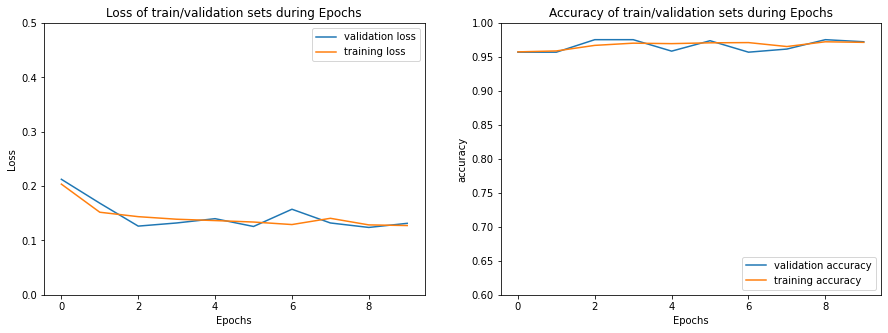

--------------------FOLD 2 --------------------


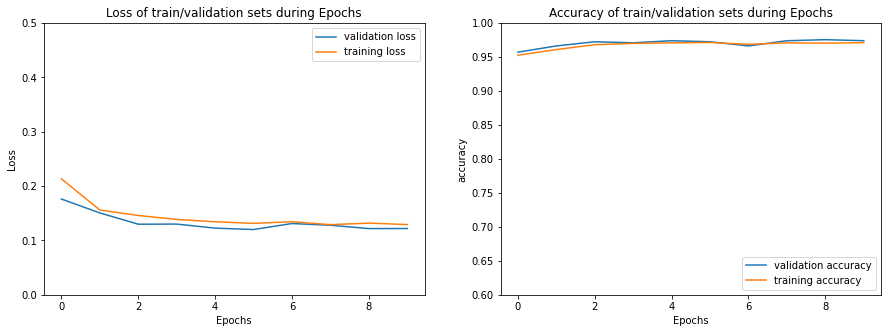

--------------------FOLD 3 --------------------


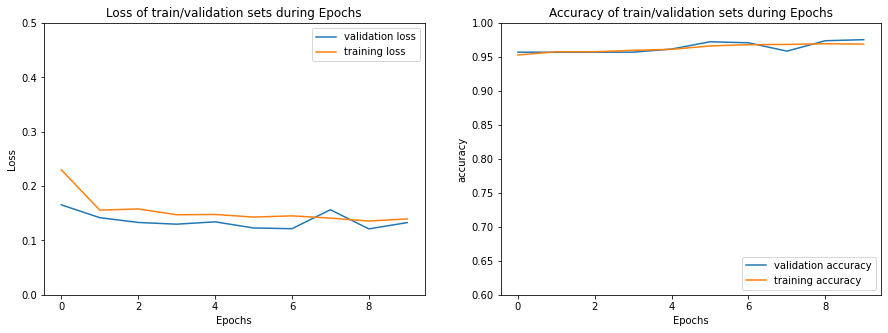

--------------------FOLD 4 --------------------


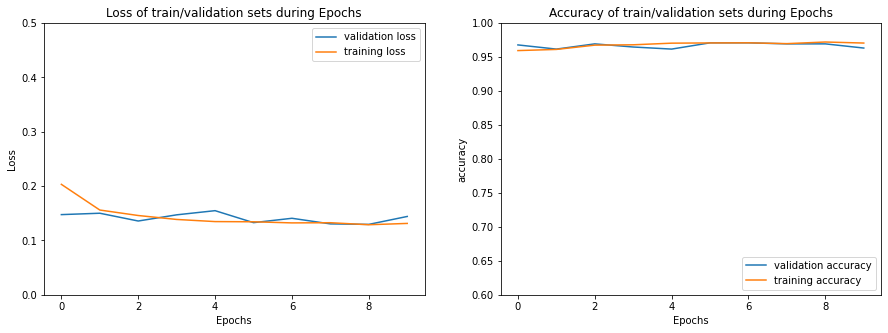

--------------------FOLD 5 --------------------


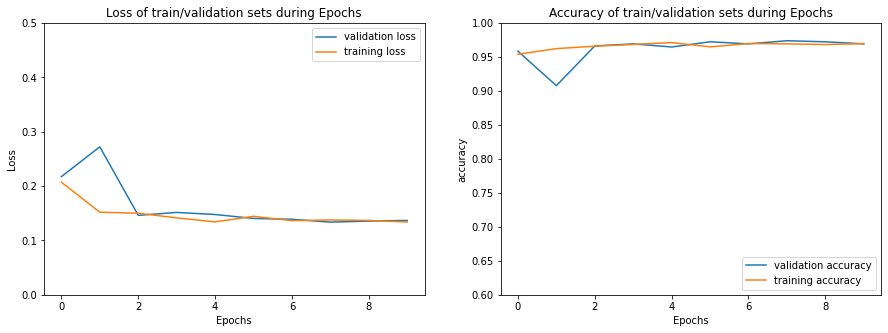

--------------------FOLD 6 --------------------


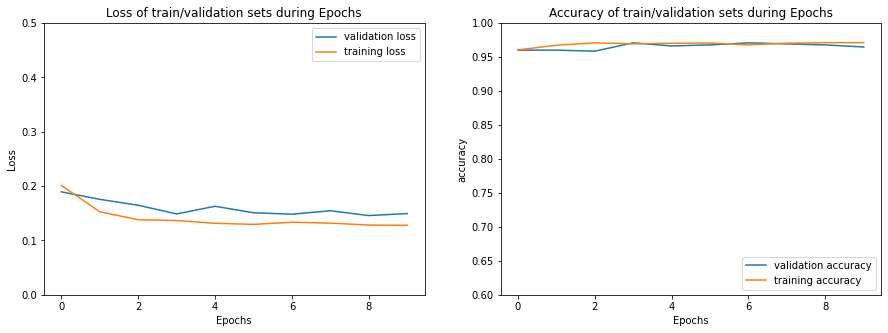

--------------------FOLD 7 --------------------


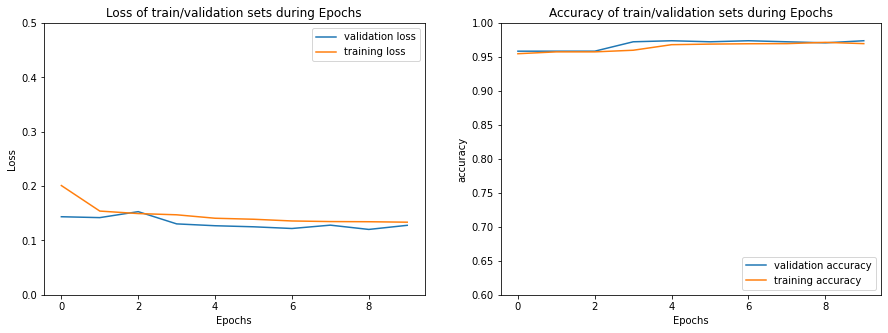

--------------------FOLD 8 --------------------


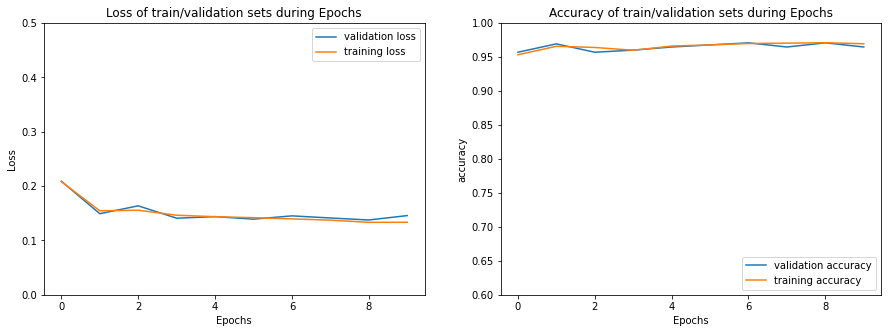

--------------------FOLD 9 --------------------


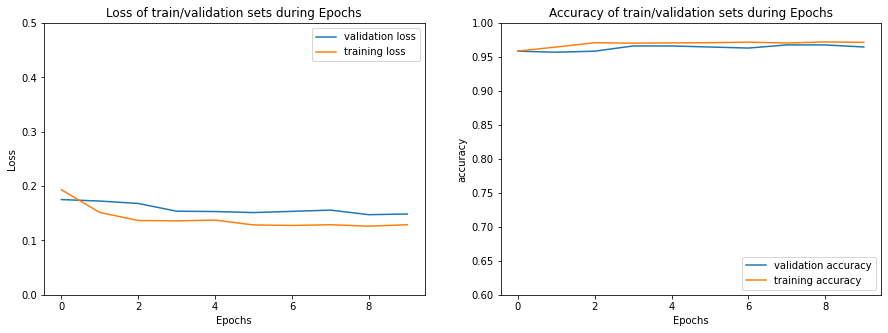

--------------------FOLD 10 --------------------


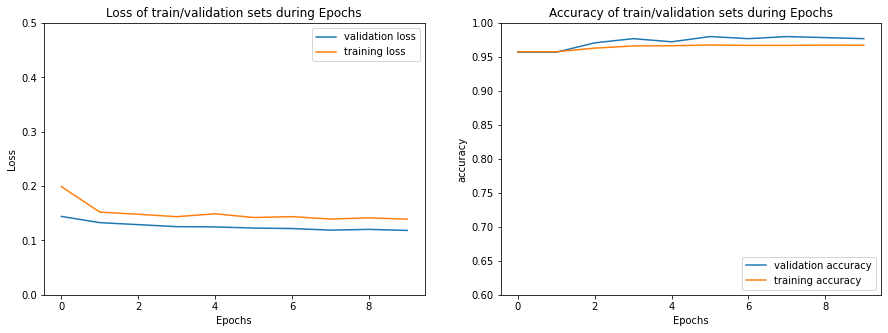

In [152]:
for i in range(len(history_per_fold)):
  print(f"--------------------FOLD {i+1} --------------------")
  plot_model(history_per_fold[i])

### Train the network with all the training set

In [153]:
model=reg_four_layer_model_config()
comp(model,lr=0.01)
history = model.fit(x_train, y_train, batch_size=32,epochs=10,validation_split=0.07, verbose=1)

Epoch 1/10
190/190 [==============================] - 2s 5ms/step - loss: 0.2093 - binary_accuracy: 0.9520 - val_loss: 0.1035 - val_binary_accuracy: 0.9803
Epoch 2/10
190/190 [==============================] - 1s 3ms/step - loss: 0.1600 - binary_accuracy: 0.9559 - val_loss: 0.0949 - val_binary_accuracy: 0.9803
Epoch 3/10
190/190 [==============================] - 1s 4ms/step - loss: 0.1538 - binary_accuracy: 0.9596 - val_loss: 0.0991 - val_binary_accuracy: 0.9803
Epoch 4/10
190/190 [==============================] - 1s 3ms/step - loss: 0.1475 - binary_accuracy: 0.9642 - val_loss: 0.0907 - val_binary_accuracy: 0.9868
Epoch 5/10
190/190 [==============================] - 1s 3ms/step - loss: 0.1425 - binary_accuracy: 0.9676 - val_loss: 0.0804 - val_binary_accuracy: 0.9890
Epoch 6/10
190/190 [==============================] - 1s 3ms/step - loss: 0.1365 - binary_accuracy: 0.9695 - val_loss: 0.0921 - val_binary_accuracy: 0.9846
Epoch 7/10
190/190 [==============================] - 1s 3ms/ste

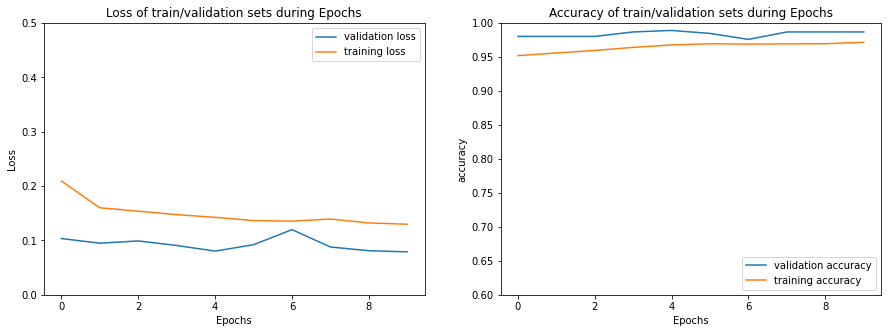

In [154]:
plot_model(history)

In [155]:
model.evaluate(x_test, y_test)

23/23 [==============================] - 0s 2ms/step - loss: 0.1311 - binary_accuracy: 0.9710


[0.1310766190290451, 0.9709944725036621]

In [156]:
y_pred=np.squeeze(model.predict(x_test))
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.

In [157]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      0.99      0.98       690
     class 1       0.81      0.50      0.62        34

    accuracy                           0.97       724
   macro avg       0.89      0.75      0.80       724
weighted avg       0.97      0.97      0.97       724



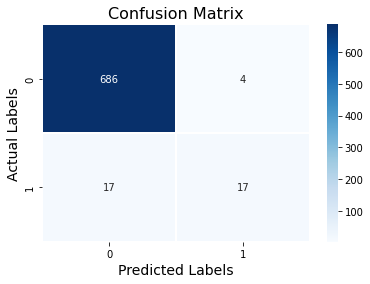

In [158]:
cm=pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [159]:
fpr, tpr, thresholds = roc_curve(y_test, np.squeeze(model.predict(x_test)))
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [160]:
auc = roc_auc_score(y_test, np.squeeze(model.predict(x_test)))

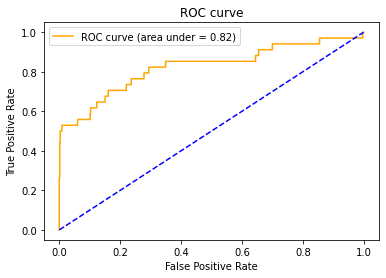

In [161]:
plt.plot(fpr,tpr, label=f'ROC curve (area under = {auc :.2f})',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

---------------
# Decision Tree
---------------


## Data Splitting for decision tree






In [121]:
x_train, x_test, y_train, y_test = train_test_split(df_x, y, test_size=0.1,random_state=50)

# Building Decision Tree by CP criterion



In [122]:
tree = DecisionTreeClassifier(criterion='gini')
path =tree.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

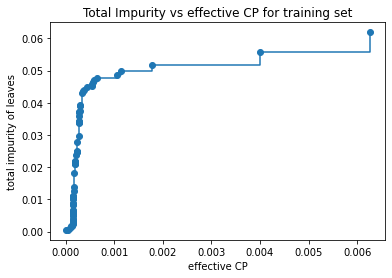

In [123]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective CP")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective CP for training set")
plt.show()

As you can see, greater alphas are corresponding to shallower trees with more impurities.

In [124]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(criterion='gini',random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(x_train, y_train)
    trees.append(tree)

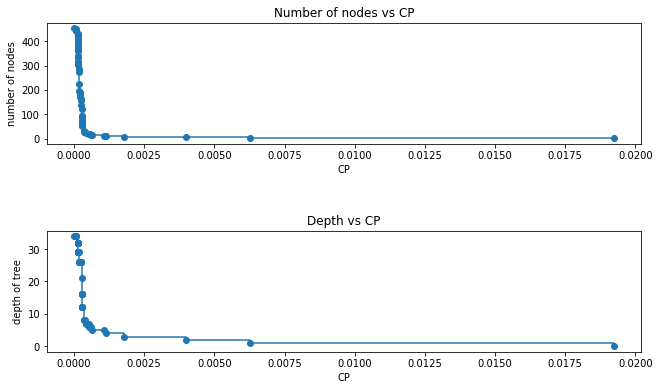

In [125]:
node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("CP")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs CP")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("CP")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs CP")
fig.tight_layout()
fig.set_size_inches(10, 6)
plt.show()

In the above graphs, we showed that lower alphas are corresponded to more complex trees with more nodes and depth.

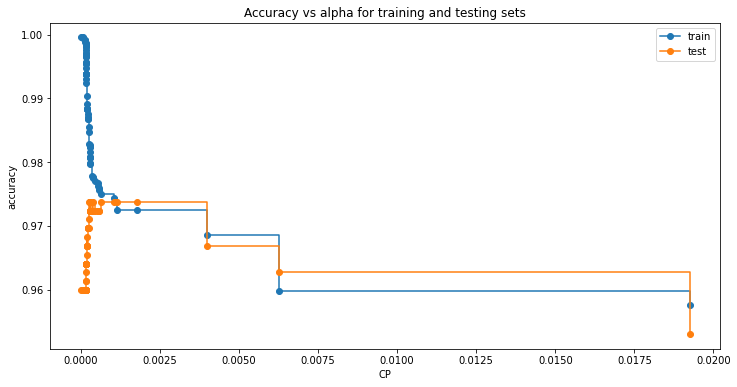

In [126]:
train_scores = [tree.score(x_train, y_train) for tree in trees]
test_scores = [tree.score(x_test, y_test) for tree in trees]

fig, ax = plt.subplots()
ax.set_xlabel("CP")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
fig.set_size_inches(12, 6)
plt.locator_params(axis="x", nbins=10)
plt.show()

We are going to choose the most suitable alpha for CP, acoording to above graph.

In [127]:
tree = DecisionTreeClassifier(criterion='gini', ccp_alpha=0.0025)
tree.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0025)

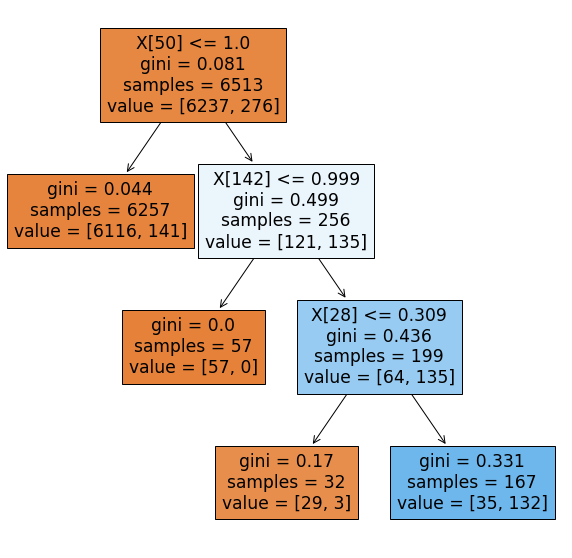

In [128]:
plt.figure(figsize=(10,10))
plot_tree(tree,filled=True)
plt.show()

In [129]:
y_pred=tree.predict(x_test)
accuracy_score(y_test,y_pred)*100

97.37569060773481

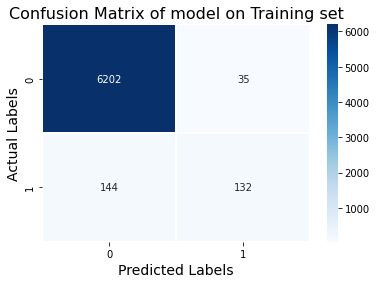

In [130]:
cm=pd.DataFrame(confusion_matrix(y_train, tree.predict(x_train)))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Training set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [133]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99       690
     class 1       0.86      0.53      0.65        34

    accuracy                           0.97       724
   macro avg       0.92      0.76      0.82       724
weighted avg       0.97      0.97      0.97       724



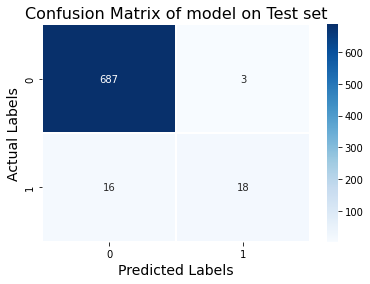

In [134]:
cm=pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Test set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [135]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [136]:
auc = roc_auc_score(y_test, y_pred)

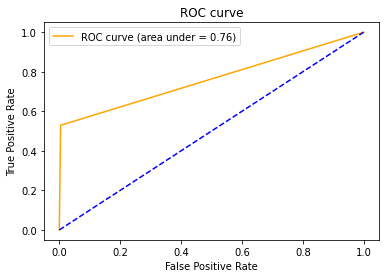

In [137]:
plt.plot(fpr,tpr, label=f'ROC curve (area under = {auc :.2f})',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

# Building Decision Tree by modifying depth and number of leaf nodes

In [138]:
depth = []
for i in range(3,20):
    clf = DecisionTreeClassifier(max_depth=i)
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)

[(3, 0.9715951391441198), (4, 0.9709799930263021), (5, 0.9729762140359807), (6, 0.9723615391139635), (7, 0.971440351323589), (8, 0.9722079292829344), (9, 0.9705196347290153), (10, 0.970519399131115), (11, 0.9686772591482665), (12, 0.9677546577704899), (13, 0.9671406896421739), (14, 0.9666796245511862), (15, 0.9651444686324954), (16, 0.9639165323758636), (17, 0.9634566452743772), (18, 0.9585446646499488), (19, 0.9599252683460083)]


In [139]:
leaf_node = []
for i in range(3,20):
    clf = DecisionTreeClassifier(max_leaf_nodes=i)
    scores = cross_val_score(estimator=clf, X=x_train, y=y_train, cv=10, n_jobs=4)
    leaf_node.append((i,scores.mean()))
print(leaf_node)

[(3, 0.9685238849151376), (4, 0.9717487489751491), (5, 0.9703667316916871), (6, 0.9723624815055649), (7, 0.9726694655697228), (8, 0.9725156201407932), (9, 0.9720547906477057), (10, 0.9723620103097641), (11, 0.9722086360766353), (12, 0.9726692299718224), (13, 0.9722088716745356), (14, 0.9729762140359804), (15, 0.9723624815055647), (16, 0.972823075400752), (17, 0.9722086360766353), (18, 0.9722086360766353), (19, 0.9728226042049514)]


So, we should either choose max_leaf_nodes 7 with accuracy 97.26% or max_depth 5 with accuracy 97.31% </br> We'll go with max_depth parameter.

In [140]:
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(x_train,y_train)

DecisionTreeClassifier(max_depth=5)

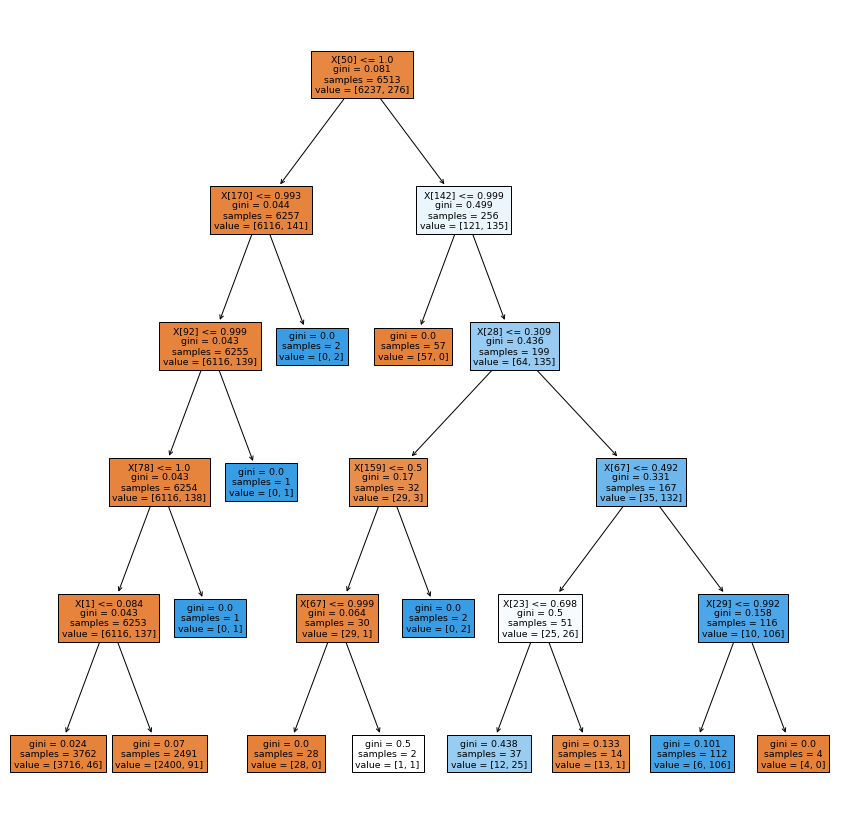

In [141]:
plt.figure(figsize=(15,15))
plot_tree(tree,filled=True)
plt.show()

In [142]:
y_pred=tree.predict(x_test)
accuracy_score(y_test,y_pred)*100

97.51381215469614

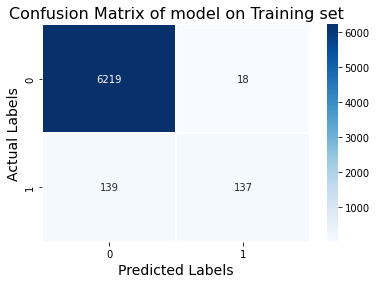

In [143]:
cm=pd.DataFrame(confusion_matrix(y_train, tree.predict(x_train)))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Training set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [144]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99       690
     class 1       0.90      0.53      0.67        34

    accuracy                           0.98       724
   macro avg       0.94      0.76      0.83       724
weighted avg       0.97      0.98      0.97       724



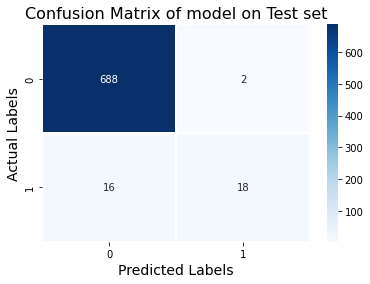

In [145]:
cm=pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True,fmt='g')
plt.title('Confusion Matrix of model on Test set', size=16)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [146]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

In [147]:
auc = roc_auc_score(y_test, y_pred)

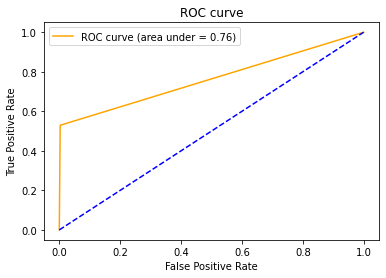

In [148]:
plt.plot(fpr,tpr, label=f'ROC curve (area under = {auc :.2f})',color='orange')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()